## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from collections import namedtuple
from collections import defaultdict
import cmath
import glob
import math
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
class Camera:
    def __init__(self, src, dst):
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        self.src = src
        self.dst = dst
        
    def compute_camera_calibration(self, images, nx, ny):
        """
        Computes camera calibration matrix.

        images - set of chess images 
        nx  number of corners in axis
        ny number of corners in y axis
        """

        objpoints = []
        imgpoints = []

        # Prepare object points as vector of vectors of points of type Point3f
        # in the format (0,0,0), (1,0,0), (2,0,0), (3,0,0) ....,(nx-1,ny-1,0)
        obj_pnts = np.zeros((nx*ny,3), np.float32)
        obj_pnts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

        for img_name in images:
            img = cv2.imread(img_name)    
            gr_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            # Identigfying corners on a gray scaled chess image
            ret, corners = cv2.findChessboardCorners(gr_img, (nx, ny), None)

            if ret == True:
                imgpoints.append(corners) # storing positions (pixels) of identified corners 
                objpoints.append(obj_pnts)
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

    
    def undistort_image(self, img):
        """
        Undistorts image using a computed calibration matrix.
        """
        if self.mtx is None: 
            print('To undistor images compute first a calibratin matrix')
            return None
        else:
            return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
    def perspective_transform(self, img):
        """
        Applies a perspective transform to get "birds-eye view"
        """
        M = cv2.getPerspectiveTransform(self.src, self.dst)
        warped_img = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)

        return warped_img
    
    def reverse_transform(self, wraped_img, img):
        """
        Unwraps image using a computed reverse calibration matrix.
        """
        Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        out_img = cv2.warpPerspective(wraped_img, Minv, (img.shape[1], img.shape[0])) 
        
        return out_img

In [3]:
class ThresholdProcesser:
    
    def __init__(self, 
                 k_size = 3, 
                 sh_thresh = (0,255), 
                 s_thresh = (0,255), 
                 m_thresh=(0,255), 
                 d_thresh=(0,1.5),
                 l_thresh=(0,255)):
        
        self.kernel_size = k_size
        self.s_channel_thresh = sh_thresh
        self.sobel_abs_thresh = s_thresh 
        self.magnitude_thresh = m_thresh
        self.direction_thresh = d_thresh
        self.l_channel_thresh = l_thresh
        
    
    def thresholds(self, img):
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, self.kernel_size)
        sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, self.kernel_size) 
        
        abs_soblex = np.absolute(sobelx)
        abs_sobley = np.absolute(sobely)
        
        out_img = np.zeros_like(gray_img)
        
        dg = np.arctan2(abs_sobley, abs_soblex)
        dg_c = (dg > self.direction_thresh[0]) & (dg < self.direction_thresh[1])
        
        abs_sobelxy = np.sqrt(np.power(sobelx,2) + np.power(sobely,2))
        mg = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
        mg_c = (mg > self.magnitude_thresh[0]) & (mg < self.magnitude_thresh[1])
        
        scaled_sobelx = np.uint8(255*abs_soblex/np.max(abs_soblex))
        absgx_c = (scaled_sobelx > self.sobel_abs_thresh[0]) & (scaled_sobelx < self.sobel_abs_thresh[1])
        
        scaled_sobely = np.uint8(255*abs_sobley/np.max(abs_sobley))
        absgy_c = (scaled_sobely > self.sobel_abs_thresh[0]) & (scaled_sobely < self.sobel_abs_thresh[1])
    
        out_img[(absgx_c & absgy_c) | (mg_c & dg_c)] = 1 
        
        return out_img


    def color_transform(self, img):

        # Convert to HLS color space, separate and threshold the S channel
        l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:,:,0]
        s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
        
        c_binary_img = np.zeros_like(s_channel)
        
        s_channel_c = (s_channel >= self.s_channel_thresh[0]) & (s_channel <= self.s_channel_thresh[1])
        l_channel_c = (l_channel >= self.l_channel_thresh[0]) & (l_channel <= self.l_channel_thresh[1])
        
        c_binary_img[s_channel_c & l_channel_c] = 1

        return c_binary_img

In [4]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):
        self.detected = False  # was the line detected in the last iteration?
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = [] #average x values of the fitted line over the last n iterations
        self.best_fit = [] #polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])] #polynomial coefficients for the most recent fit
        self.radius_of_curvature = None #radius of curvature of the line in some units
        self.line_base_pos = None #distance of vehicle center from the center of lines
        self.allx = None #x values for detected line pixels
        self.ally = None #y values for detected line pixels

In [5]:
class LaneDetector:
    
    def __init__(self, nwindows, 
                 margin, 
                 minpix,
                 n_frames=3):
        
        self.left_lane = Line()
        self.right_lane = Line()
        self.nwindows = nwindows
        self.margin = margin
        self.minpix = minpix
        self.n_frames = n_frames

    def fit_poly_for_lines(self, leftx, lefty, rightx, righty):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit
    
    def generate_plotting_values(self, img):
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        l_best_fit = np.mean(self.left_lane.best_fit, axis=0)
        r_best_fit = np.mean(self.right_lane.best_fit, axis=0)
        left_fitx = l_best_fit[0]*(ploty)**2 + l_best_fit[1]*(ploty) + l_best_fit[2]
        right_fitx = r_best_fit[0]*(ploty)**2 + r_best_fit[1]*(ploty) + r_best_fit[2]

        return left_fitx, right_fitx

    def find_lanes_w_histogram(self, binary_warped_img):
    
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)

        # Find the peak of the left and right halves of the histogram, starting point for the left and right lines
        leftx_current = np.argmax(histogram[:midpoint])
        rightx_current = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped_img.shape[0]//nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped_img.nonzero()
        nzy = np.array(nonzero[0])
        nzx = np.array(nonzero[1])

        left_lane_inds = []
        right_lane_inds = []

        for window in range(self.nwindows):

            # Identify window boundaries
            win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
            win_y_high = binary_warped_img.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin  
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            # We consider pixels which are within the height of the current window
            rel_pix = (nzy < win_y_high) & (nzy >= win_y_low)
            good_left_inds = (rel_pix & (nzx >= win_xleft_low) & (nzx < win_xleft_high)).nonzero()[0]    
            good_right_inds = (rel_pix & (nzx < win_xright_high) & (nzx >= win_xright_low)).nonzero()[0] 

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If # of pixels > minpix pixels, we recenter next window
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nzx[good_left_inds]))

            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nzx[good_right_inds]))


        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        self.left_lane.allx = nzx[left_lane_inds]
        self.left_lane.ally = nzy[left_lane_inds] 
        self.right_lane.allx = nzx[right_lane_inds]
        self.right_lane.ally = nzy[right_lane_inds]


    def search_around_poly(self, b_warped_img):
        # Grab activated pixels
        nonzero = b_warped_img.nonzero()
        nzy = np.array(nonzero[0])
        nzx = np.array(nonzero[1])

        left_fit = self.left_lane.current_fit
        right_fit = self.right_lane.current_fit
        
        # Set the area of search based on activated x-values within the +/- margin of our polynomial function
        left_lane_inds = ((nzx > (left_fit[0]*(nzy**2) + left_fit[1]*nzy + 
                        left_fit[2] - self.margin)) & (nzx < (left_fit[0]*(nzy**2) + 
                        left_fit[1]*nzy + left_fit[2] + self.margin)))
        right_lane_inds = ((nzx > (right_fit[0]*(nzy**2) + right_fit[1]*nzy + 
                        right_fit[2] - self.margin)) & (nzx < (right_fit[0]*(nzy**2) + 
                        right_fit[1]*nzy + right_fit[2] + self.margin)))

        # Extract left and right line pixel positions
        self.left_lane.allx = nzx[left_lane_inds]
        self.left_lane.ally = nzy[left_lane_inds] 
        self.right_lane.allx = nzx[right_lane_inds]
        self.right_lane.ally = nzy[right_lane_inds]

    def detect_lines_images(self, warped_image):
        
        self.find_lanes_w_histogram(warped_image)
        left_fit, right_fit = self.fit_poly_for_lines(self.left_lane.allx, self.left_lane.ally, self.right_lane.allx, self.right_lane.ally)
        self.left_lane.best_fit = [left_fit]
        self.right_lane.best_fit = [right_fit]
        left_fitx, right_fitx = self.generate_plotting_values(warped_image)
        self.left_lane.bestx = left_fitx
        self.right_lane.bestx = right_fitx
        self.left_lane.best_fit.append(left_fit)
        self.right_lane.best_fit.append(right_fit)
            
    def detect_lines_video(self, warped_image):

        if not self.left_lane.detected: # If we could not detect the lanes, we start with histogram search 
            self.find_lanes_w_histogram(warped_image)
        else: # In case we detected we search in the region of the line from the previous frame
            self.search_around_poly(warped_image)

        left_fit, right_fit = self.fit_poly_for_lines(self.left_lane.allx, self.left_lane.ally, self.right_lane.allx, self.right_lane.ally)
        
        ## Check that the detected lines are roughly paraller
        ## or if its the first frame we anyways start with histogram search
        if  np.abs(left_fit[0] - right_fit[0]) < 0.01  or not len(self.left_lane.bestx):
            self.left_lane.detected = True
            self.left_lane.current_fit = left_fit
            
            self.right_lane.detected = True
            self.right_lane.current_fit = right_fit
            
            if len(self.left_lane.recent_xfitted) == self.n_frames:
                self.left_lane.recent_xfitted.pop(0)
                self.right_lane.recent_xfitted.pop(0)
                self.left_lane.best_fit.pop(0)
                self.right_lane.best_fit.pop(0)
            
            self.left_lane.best_fit.append(left_fit)
            self.right_lane.best_fit.append(right_fit)
            
            left_curverad, right_curverad = self.measure_curvature(warped_image.shape[0])
                
            self.left_lane.radius_of_curvature = left_curverad
            self.right_lane.radius_of_curvature = right_curverad
            
            self.left_lane.line_base_pos = self.find_lane_center(warped_image.shape[0], left_fit, right_fit)
            
            left_fitx, right_fitx = self.generate_plotting_values(warped_image)
            
            self.left_lane.recent_xfitted.append(left_fitx)
            self.left_lane.bestx = np.mean(self.left_lane.recent_xfitted, axis=0).astype(int)
            
            self.right_lane.recent_xfitted.append(right_fitx)
            self.right_lane.bestx = np.mean(self.right_lane.recent_xfitted, axis=0).astype(int)
            
        else:
            self.left_lane.detected = False
            self.right_lane.detected = False


    def measure_curvature(self, h):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        ploty = np.linspace(0, h-1, h, dtype=np.int32)                                              
        y_eval = np.max(ploty)
        
        ym = 30/720 # meters per pixel in y dimension
        xm = 3.7/700 # meters per pixel in x dimension
        
        left_fit_cr, right_fit_cr = self.fit_poly_for_lines(self.left_lane.allx*xm, self.left_lane.ally*ym, self.right_lane.allx*xm, self.right_lane.ally*ym)
                                              
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_curverad, right_curverad
    
    def find_lane_center(self, h, left_fit, right_fit):
        left_lane_c = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_lane_c = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        return left_lane_c + (right_lane_c - left_lane_c) /2

In [6]:
# HYPERPARAMETERS
nwindows = 9 # choose the number of sliding windows
margin = 100 # set the width of the windows +/- margin
minpix = 30 # set minimum number of pixels found to recenter window
kernel_size = 5
s_channel_thresh = (100, 255) 
sobel_abs_thresh = (10, 150) 
magnitude_thresh = (100, 255) 
direction_thresh = (0.7, 1.4)
l_channel_thresh = (150, 255)

src = np.float32([(678,443),(605,443),(285,665),(1019,665)]) # in x,y order not matrix convention
dst = np.float32([(919,0),(285,0),(285,665),(919,665)])

vehicle_center = (1240/2 - 285)/(1019 - 285)*(919 - 285) + 285

## Computing camera calibration matrix and distortion coefficients
images = glob.glob('camera_cal/calibration*.jpg')
camera = Camera(src, dst)
camera.compute_camera_calibration(images, 9, 6)

threshold_processer = ThresholdProcesser(kernel_size, 
                                        s_channel_thresh,
                                        sobel_abs_thresh,
                                        magnitude_thresh,
                                        direction_thresh,
                                        l_channel_thresh) 

In [15]:
def process_image(img_path, camera, threshold_processer, lane_detector):

    # Undistort image using computed camera calibration matrix
        
    original_img = cv2.imread(img_path) 
    img = np.copy(original_img)
    
    img_name = img_path.split('\\')[1]
    folder_out = 'output_images\\'
    
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,10))
    
    undistorted_img = camera.undistort_image(img)
    
    ax1.set_title('Undistorted image', fontsize=20)
    ax1.imshow(undistorted_img)
    mpimg.imsave('{}undistort_{}'.format(folder_out, img_name), undistorted_img)
        
    # Applying color transforms and gradient thresholds to get a thresholded binary image
    schbinary = threshold_processer.color_transform(img)
    g_binary = threshold_processer.thresholds(img)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(schbinary)
    combined_binary[(schbinary == 1) | (g_binary == 1)] = 1
    
    ax2.set_title('Thresholded image', fontsize=20)
    ax2.imshow(combined_binary, cmap='gray')
    mpimg.imsave('{}binary_{}'.format(folder_out, img_name), combined_binary)
    
    b_warped_img = camera.perspective_transform(combined_binary)
    
    ax3.set_title('Warped image', fontsize=20)
    ax3.imshow(b_warped_img, cmap='gray')
    mpimg.imsave('{}warped_{}'.format(folder_out, img_name), b_warped_img)

    lane_detector.detect_lines_images(b_warped_img)
    
    ax4.set_title('Detected lanes', fontsize=20)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0], dtype=np.int32)
    ax4.plot(lane_detector.left_lane.bestx, ploty, color='yellow')
    ax4.plot(lane_detector.right_lane.bestx, ploty, color='yellow')
    ax4.imshow(b_warped_img)
    mpimg.imsave('{}warped_lines_{}'.format(folder_out, img_name), b_warped_img)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(b_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0], dtype=np.int32)
    pts_left = np.array([np.transpose(np.vstack([lane_detector.left_lane.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lane_detector.right_lane.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = camera.reverse_transform(color_warp, img) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    ax5.set_title('Final image', fontsize=20)
    ax5.imshow(result)
    mpimg.imsave('{}final_{}'.format(folder_out, img_name), result)
    
    plt.show()
    
    return result

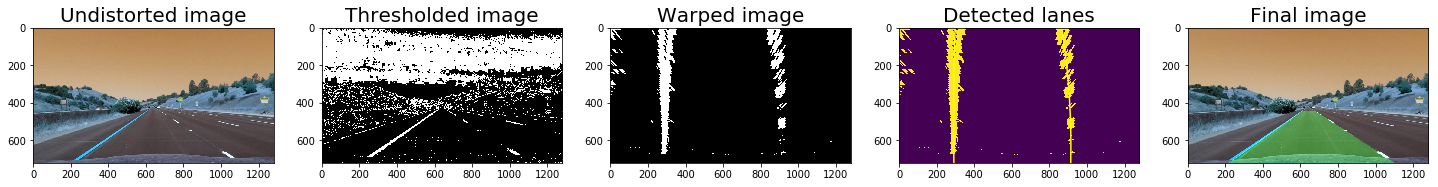

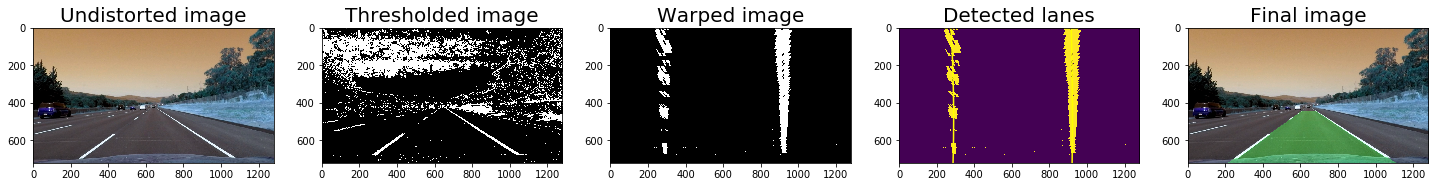

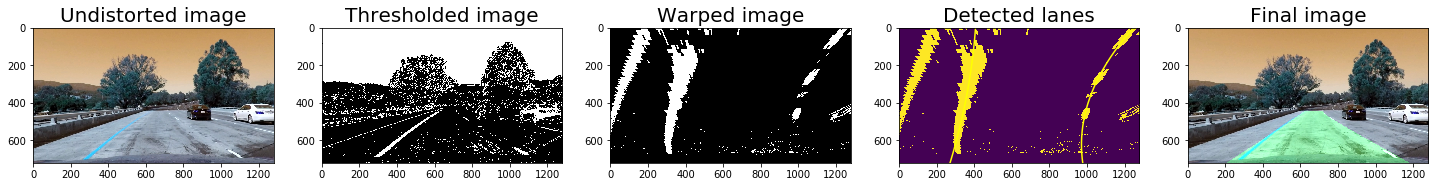

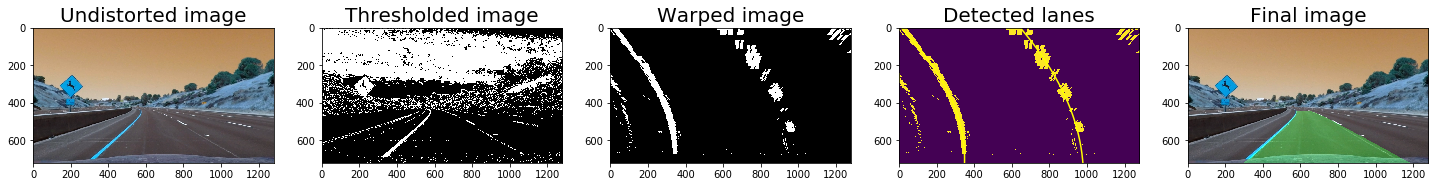

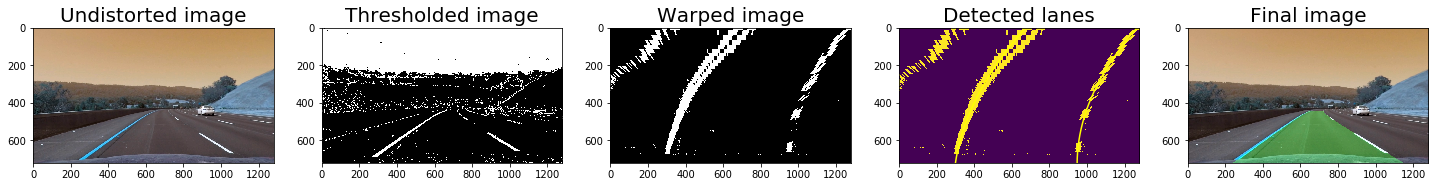

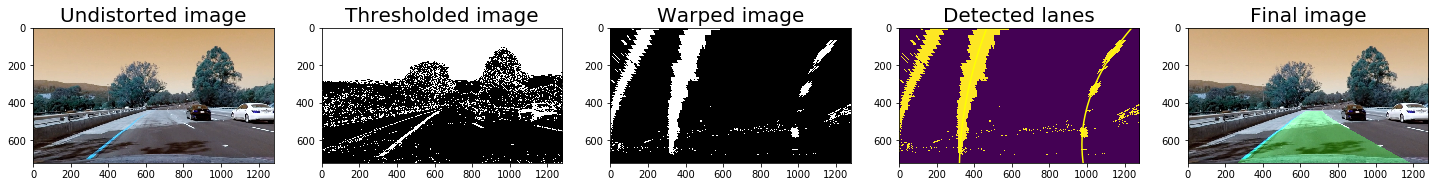

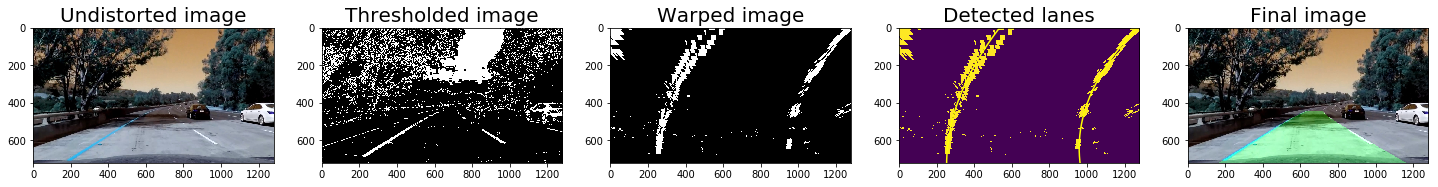

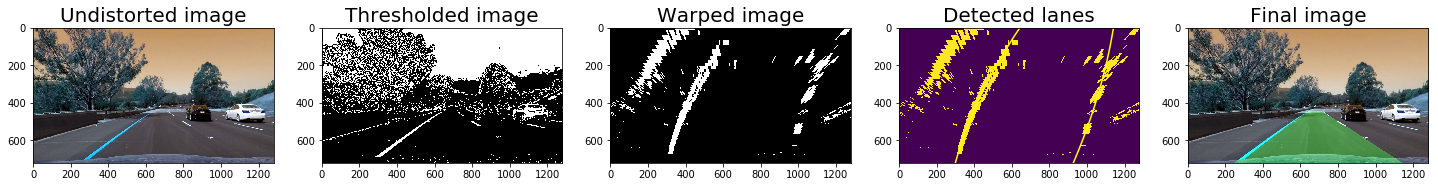

In [16]:
lane_detector = LaneDetector(nwindows, margin, minpix)

test_images = glob.glob('test_images/*.jpg')

for img_path in test_images:
    out_img = process_image(img_path, camera, threshold_processer, lane_detector)

In [17]:
def process_video(image, camera, threshold_processer, lane_detector):

    # Undistort image using computed camera calibration matrix
    img = np.copy(image)
    undistorted_img = camera.undistort_image(img)
    
    # Applying color transforms and gradient thresholds to get a thresholded binary image
    schbinary = threshold_processer.color_transform(img)
    g_binary = threshold_processer.thresholds(img)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(schbinary)
    combined_binary[(schbinary == 1) | (g_binary == 1)] = 1
    
    # Apply a perspective transform to rectify binary image ("birds-eye view")
    b_warped_img = camera.perspective_transform(combined_binary)
    
 
    lane_detector.detect_lines_video(b_warped_img)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(b_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0], dtype=np.int32)
    pts_left = np.array([np.transpose(np.vstack([lane_detector.left_lane.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lane_detector.right_lane.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))  
    cv2.polylines(color_warp, np.int_([pts_left]), isClosed=False, color=(255,0,0), thickness=30)
    cv2.polylines(color_warp, np.int_([pts_right]), isClosed=False, color=(255,0,0), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = camera.reverse_transform(color_warp, img) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

    #print(lane_detector.left_lane.radius_of_curvature, lane_detector.right_lane.radius_of_curvature)
    curvature = 'Radius of curvature: {:0.1f} meters'.format((lane_detector.left_lane.radius_of_curvature+lane_detector.right_lane.radius_of_curvature) / 2)
    cv2.putText(result, curvature, (50,50), cv2.FONT_HERSHEY_DUPLEX, 1.6, (255,255,255), 2, cv2.LINE_AA)
    
    position = (vehicle_center - lane_detector.left_lane.line_base_pos) * 3.7/700
    position_text = 'Vehicle is {:0.2f} meters {:s} of the center'.format(abs(position), 'left' if position < 0 else 'right') 
    cv2.putText(result, position_text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1.6, (255,255,255), 2, cv2.LINE_AA)
    
    
    #plt.imshow(result)
    #plt.show()
    
    return result

In [21]:
white_output = 'project_video_output.mp4'
lane_detector_v = LaneDetector(nwindows, margin, minpix)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lambda x: process_video(x, camera, threshold_processer, lane_detector_v)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_video_output.mp4.


t:   0%|          | 2/1260 [02:11<02:32,  8.25it/s, now=None]
                                                             


Moviepy - Writing video project_video_output.mp4



t:   0%|          | 2/1260 [01:47<02:19,  8.99it/s, now=None]

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

t:   0%|          | 2/1260 [00:00<02:18,  9.11it/s, now=None]

t:   0%|          | 3/1260 [00:00<02:54,  7.19it/s, now=None]

t:   0%|          | 4/1260 [00:00<03:20,  6.26it/s, now=None]

t:   0%|          | 5/1260 [00:00<03:40,  5.70it/s, now=None]

t:   0%|          | 6/1260 [00:01<03:49,  5.46it/s, now=None]

t:   1%|          | 7/1260 [00:01<03:55,  5.33it/s, now=None]

t:   1%|          | 8/1260 [00:01<04:01,  5.18it/s, now=None]

t:   1%|          | 9/1260 [00:01<04:13,  4.93it/s, now=None]

t:   1%|          | 10/1260 [00:01<04:20,  4.79it/s, now=None]

t:   1%|          | 11/1260 [00:02<04:18,  4.83it/s, now=None]

t:   1%|          | 12/1260 [00:02<04:13,  4.92it/s, now=None]

t:   1%|          | 13/1260 [00:02<04:13,  4.92it/s, now=None]

t:   1%|          | 14/1260 [00:02<04:12,  4.93it/s, now=None]

t:   1%|          | 15/1260 [00:02<04:10,  4.97it/s, now=N

t:  10%|█         | 126/1260 [00:27<04:40,  4.04it/s, now=None]

t:  10%|█         | 127/1260 [00:27<04:24,  4.28it/s, now=None]

t:  10%|█         | 128/1260 [00:27<04:09,  4.54it/s, now=None]

t:  10%|█         | 129/1260 [00:28<03:58,  4.74it/s, now=None]

t:  10%|█         | 130/1260 [00:28<03:52,  4.85it/s, now=None]

t:  10%|█         | 131/1260 [00:28<03:50,  4.89it/s, now=None]

t:  10%|█         | 132/1260 [00:28<03:45,  5.00it/s, now=None]

t:  11%|█         | 133/1260 [00:28<03:44,  5.03it/s, now=None]

t:  11%|█         | 134/1260 [00:28<03:43,  5.03it/s, now=None]

t:  11%|█         | 135/1260 [00:29<03:43,  5.03it/s, now=None]

t:  11%|█         | 136/1260 [00:29<03:39,  5.11it/s, now=None]

t:  11%|█         | 137/1260 [00:29<03:40,  5.10it/s, now=None]

t:  11%|█         | 138/1260 [00:29<03:40,  5.08it/s, now=None]

t:  11%|█         | 139/1260 [00:29<03:38,  5.13it/s, now=None]

t:  11%|█         | 140/1260 [00:30<03:37,  5.15it/s, now=None]

t:  11%|█         | 141/1

t:  20%|██        | 252/1260 [00:56<04:35,  3.65it/s, now=None]

t:  20%|██        | 253/1260 [00:56<04:13,  3.97it/s, now=None]

t:  20%|██        | 254/1260 [00:56<03:54,  4.28it/s, now=None]

t:  20%|██        | 255/1260 [00:57<03:41,  4.53it/s, now=None]

t:  20%|██        | 256/1260 [00:57<03:32,  4.72it/s, now=None]

t:  20%|██        | 257/1260 [00:57<03:25,  4.87it/s, now=None]

t:  20%|██        | 258/1260 [00:57<03:33,  4.69it/s, now=None]

t:  21%|██        | 259/1260 [00:57<03:28,  4.81it/s, now=None]

t:  21%|██        | 260/1260 [00:58<03:24,  4.88it/s, now=None]

t:  21%|██        | 261/1260 [00:58<03:21,  4.96it/s, now=None]

t:  21%|██        | 262/1260 [00:58<03:18,  5.03it/s, now=None]

t:  21%|██        | 263/1260 [00:58<03:20,  4.98it/s, now=None]

t:  21%|██        | 264/1260 [00:58<03:19,  5.00it/s, now=None]

t:  21%|██        | 265/1260 [00:59<03:17,  5.03it/s, now=None]

t:  21%|██        | 266/1260 [00:59<03:16,  5.07it/s, now=None]

t:  21%|██        | 267/1

t:  30%|███       | 378/1260 [01:26<03:22,  4.36it/s, now=None]

t:  30%|███       | 379/1260 [01:26<03:14,  4.54it/s, now=None]

t:  30%|███       | 380/1260 [01:26<03:08,  4.66it/s, now=None]

t:  30%|███       | 381/1260 [01:26<03:07,  4.68it/s, now=None]

t:  30%|███       | 382/1260 [01:27<03:06,  4.71it/s, now=None]

t:  30%|███       | 383/1260 [01:27<03:05,  4.72it/s, now=None]

t:  30%|███       | 384/1260 [01:27<03:03,  4.77it/s, now=None]

t:  31%|███       | 385/1260 [01:27<03:07,  4.67it/s, now=None]

t:  31%|███       | 386/1260 [01:27<03:01,  4.81it/s, now=None]

t:  31%|███       | 387/1260 [01:28<02:58,  4.89it/s, now=None]

t:  31%|███       | 388/1260 [01:28<02:55,  4.97it/s, now=None]

t:  31%|███       | 389/1260 [01:28<02:54,  5.00it/s, now=None]

t:  31%|███       | 390/1260 [01:28<02:55,  4.96it/s, now=None]

t:  31%|███       | 391/1260 [01:28<02:54,  4.99it/s, now=None]

t:  31%|███       | 392/1260 [01:29<02:56,  4.92it/s, now=None]

t:  31%|███       | 393/1

t:  40%|████      | 504/1260 [01:57<02:40,  4.72it/s, now=None]

t:  40%|████      | 505/1260 [01:57<02:37,  4.79it/s, now=None]

t:  40%|████      | 506/1260 [01:57<02:35,  4.86it/s, now=None]

t:  40%|████      | 507/1260 [01:57<02:34,  4.87it/s, now=None]

t:  40%|████      | 508/1260 [01:57<02:33,  4.91it/s, now=None]

t:  40%|████      | 509/1260 [01:58<02:31,  4.95it/s, now=None]

t:  40%|████      | 510/1260 [01:58<02:31,  4.96it/s, now=None]

t:  41%|████      | 511/1260 [01:58<02:33,  4.90it/s, now=None]

t:  41%|████      | 512/1260 [01:58<02:38,  4.71it/s, now=None]

t:  41%|████      | 513/1260 [01:58<02:40,  4.67it/s, now=None]

t:  41%|████      | 514/1260 [01:59<02:42,  4.60it/s, now=None]

t:  41%|████      | 515/1260 [01:59<02:44,  4.53it/s, now=None]

t:  41%|████      | 516/1260 [01:59<03:04,  4.03it/s, now=None]

t:  41%|████      | 517/1260 [02:00<03:40,  3.37it/s, now=None]

t:  41%|████      | 518/1260 [02:00<04:04,  3.04it/s, now=None]

t:  41%|████      | 519/1

t:  50%|█████     | 630/1260 [02:29<02:29,  4.20it/s, now=None]

t:  50%|█████     | 631/1260 [02:30<02:26,  4.28it/s, now=None]

t:  50%|█████     | 632/1260 [02:30<02:22,  4.39it/s, now=None]

t:  50%|█████     | 633/1260 [02:30<02:22,  4.39it/s, now=None]

t:  50%|█████     | 634/1260 [02:30<02:22,  4.40it/s, now=None]

t:  50%|█████     | 635/1260 [02:31<02:20,  4.46it/s, now=None]

t:  50%|█████     | 636/1260 [02:31<02:16,  4.56it/s, now=None]

t:  51%|█████     | 637/1260 [02:31<02:15,  4.61it/s, now=None]

t:  51%|█████     | 638/1260 [02:31<02:14,  4.62it/s, now=None]

t:  51%|█████     | 639/1260 [02:31<02:11,  4.73it/s, now=None]

t:  51%|█████     | 640/1260 [02:32<02:09,  4.80it/s, now=None]

t:  51%|█████     | 641/1260 [02:32<02:08,  4.83it/s, now=None]

t:  51%|█████     | 642/1260 [02:32<02:07,  4.83it/s, now=None]

t:  51%|█████     | 643/1260 [02:32<02:07,  4.84it/s, now=None]

t:  51%|█████     | 644/1260 [02:33<02:32,  4.05it/s, now=None]

t:  51%|█████     | 645/1

t:  60%|██████    | 756/1260 [03:01<01:42,  4.92it/s, now=None]

t:  60%|██████    | 757/1260 [03:01<01:42,  4.92it/s, now=None]

t:  60%|██████    | 758/1260 [03:01<01:41,  4.96it/s, now=None]

t:  60%|██████    | 759/1260 [03:01<01:41,  4.94it/s, now=None]

t:  60%|██████    | 760/1260 [03:01<01:40,  4.99it/s, now=None]

t:  60%|██████    | 761/1260 [03:02<01:39,  5.01it/s, now=None]

t:  60%|██████    | 762/1260 [03:02<02:11,  3.79it/s, now=None]

t:  61%|██████    | 763/1260 [03:02<02:34,  3.22it/s, now=None]

t:  61%|██████    | 764/1260 [03:03<02:49,  2.93it/s, now=None]

t:  61%|██████    | 765/1260 [03:03<02:59,  2.76it/s, now=None]

t:  61%|██████    | 766/1260 [03:04<03:04,  2.68it/s, now=None]

t:  61%|██████    | 767/1260 [03:04<03:08,  2.61it/s, now=None]

t:  61%|██████    | 768/1260 [03:04<03:12,  2.55it/s, now=None]

t:  61%|██████    | 769/1260 [03:05<02:55,  2.79it/s, now=None]

t:  61%|██████    | 770/1260 [03:05<02:31,  3.23it/s, now=None]

t:  61%|██████    | 771/1

t:  70%|███████   | 882/1260 [03:32<01:17,  4.91it/s, now=None]

t:  70%|███████   | 883/1260 [03:33<01:17,  4.89it/s, now=None]

t:  70%|███████   | 884/1260 [03:33<01:16,  4.92it/s, now=None]

t:  70%|███████   | 885/1260 [03:33<01:16,  4.93it/s, now=None]

t:  70%|███████   | 886/1260 [03:33<01:15,  4.94it/s, now=None]

t:  70%|███████   | 887/1260 [03:33<01:15,  4.95it/s, now=None]

t:  70%|███████   | 888/1260 [03:34<01:14,  4.97it/s, now=None]

t:  71%|███████   | 889/1260 [03:34<01:14,  4.99it/s, now=None]

t:  71%|███████   | 890/1260 [03:34<01:13,  5.02it/s, now=None]

t:  71%|███████   | 891/1260 [03:34<01:14,  4.92it/s, now=None]

t:  71%|███████   | 892/1260 [03:34<01:16,  4.81it/s, now=None]

t:  71%|███████   | 893/1260 [03:35<01:16,  4.80it/s, now=None]

t:  71%|███████   | 894/1260 [03:35<01:16,  4.79it/s, now=None]

t:  71%|███████   | 895/1260 [03:35<01:35,  3.80it/s, now=None]

t:  71%|███████   | 896/1260 [03:36<01:51,  3.28it/s, now=None]

t:  71%|███████   | 897/1

t:  80%|███████▉  | 1007/1260 [04:04<00:53,  4.69it/s, now=None]

t:  80%|████████  | 1008/1260 [04:04<00:53,  4.73it/s, now=None]

t:  80%|████████  | 1009/1260 [04:05<00:52,  4.80it/s, now=None]

t:  80%|████████  | 1010/1260 [04:05<00:51,  4.83it/s, now=None]

t:  80%|████████  | 1011/1260 [04:05<00:51,  4.84it/s, now=None]

t:  80%|████████  | 1012/1260 [04:05<00:57,  4.33it/s, now=None]

t:  80%|████████  | 1013/1260 [04:06<01:11,  3.46it/s, now=None]

t:  80%|████████  | 1014/1260 [04:06<01:21,  3.03it/s, now=None]

t:  81%|████████  | 1015/1260 [04:07<01:28,  2.76it/s, now=None]

t:  81%|████████  | 1016/1260 [04:07<01:33,  2.61it/s, now=None]

t:  81%|████████  | 1017/1260 [04:08<01:37,  2.48it/s, now=None]

t:  81%|████████  | 1018/1260 [04:08<01:39,  2.43it/s, now=None]

t:  81%|████████  | 1019/1260 [04:08<01:35,  2.53it/s, now=None]

t:  81%|████████  | 1020/1260 [04:09<01:21,  2.96it/s, now=None]

t:  81%|████████  | 1021/1260 [04:09<01:11,  3.34it/s, now=None]

t:  81%|██

t:  90%|████████▉ | 1131/1260 [04:38<00:33,  3.89it/s, now=None]

t:  90%|████████▉ | 1132/1260 [04:38<00:31,  4.00it/s, now=None]

t:  90%|████████▉ | 1133/1260 [04:38<00:31,  4.04it/s, now=None]

t:  90%|█████████ | 1134/1260 [04:38<00:31,  3.99it/s, now=None]

t:  90%|█████████ | 1135/1260 [04:39<00:31,  3.99it/s, now=None]

t:  90%|█████████ | 1136/1260 [04:39<00:31,  4.00it/s, now=None]

t:  90%|█████████ | 1137/1260 [04:39<00:29,  4.13it/s, now=None]

t:  90%|█████████ | 1138/1260 [04:39<00:28,  4.31it/s, now=None]

t:  90%|█████████ | 1139/1260 [04:40<00:26,  4.51it/s, now=None]

t:  90%|█████████ | 1140/1260 [04:40<00:25,  4.68it/s, now=None]

t:  91%|█████████ | 1141/1260 [04:40<00:24,  4.77it/s, now=None]

t:  91%|█████████ | 1142/1260 [04:40<00:24,  4.76it/s, now=None]

t:  91%|█████████ | 1143/1260 [04:40<00:24,  4.82it/s, now=None]

t:  91%|█████████ | 1144/1260 [04:41<00:24,  4.82it/s, now=None]

t:  91%|█████████ | 1145/1260 [04:41<00:23,  4.83it/s, now=None]

t:  91%|██

t: 100%|█████████▉| 1255/1260 [05:10<00:01,  3.43it/s, now=None]

t: 100%|█████████▉| 1256/1260 [05:10<00:01,  3.11it/s, now=None]

t: 100%|█████████▉| 1257/1260 [05:10<00:01,  2.84it/s, now=None]

t: 100%|█████████▉| 1258/1260 [05:11<00:00,  2.65it/s, now=None]

t: 100%|█████████▉| 1259/1260 [05:11<00:00,  2.56it/s, now=None]

t: 100%|██████████| 1260/1260 [05:12<00:00,  2.54it/s, now=None]

                                                                


Moviepy - Done !


t:   0%|          | 2/1260 [07:25<02:32,  8.25it/s, now=None]
                                                             


Moviepy - video ready project_video_output.mp4


t:   0%|          | 2/1260 [07:00<02:19,  8.99it/s, now=None]

Wall time: 5min 13s


In [22]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}">
</video>
""".format(white_output))